In [67]:
'''
Dataset + Preprocessing Code

CelebA-HQ resized to 128×128×3
We apply random rectangular masks (10–25% area).

'''

# import necessary libraries

import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import cv2
import random

IMG_SIZE = 128
BATCH_SIZE = 16


In [68]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("badasstechie/celebahq-resized-256x256")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'celebahq-resized-256x256' dataset.
Path to dataset files: /kaggle/input/celebahq-resized-256x256


In [69]:
DATASET_PATH = path

# Load & resize function
def load_and_resize(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))   # RESIZED IMAGE 128×128
    img = img / 255.0                             # normalize 0-1
    return img.astype(np.float32)


In [70]:
# Random mask generator (10-25% of area)

def random_mask(img):
    h, w, _ = img.shape
    area = np.random.uniform(0.10, 0.25)

    mask_h = int(h * np.sqrt(area))
    mask_w = int(w * np.sqrt(area))

    x = np.random.randint(0, h-mask_h)
    y = np.random.randint(0, w-mask_w)

    img_masked = img.copy()
    img_masked[x:x+mask_h, y:y+mask_w] = 0        # damaged region created
    return img_masked


In [71]:

# Generator for tf.data
def data_gen():
    for root, _, files in os.walk(DATASET_PATH):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".png"):
                img = load_and_resize(os.path.join(root, file))
                masked = random_mask(img)

                yield masked, img  # (input, target)


In [72]:
# tf.data pipeline
dataset = tf.data.Dataset.from_generator(
    data_gen,
    output_types=(tf.float32, tf.float32),
    output_shapes=((128,128,3),(128,128,3))
).shuffle(500).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Dataset loaded & RESIZED to 128x128 successfully ✔")
dataset

Dataset loaded & RESIZED to 128x128 successfully ✔


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None))>

# **U-Net Autoencoder Implementation**

In [73]:
# Custom loss function: L = MAE + λ*(1-SSIM)

lambda_ssim = 0.2   # can tune (0.2–0.4 good start)

def combined_loss(y_true, y_pred):
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    ssim = tf.image.ssim(y_true, y_pred, max_val=1.0)
    ssim_loss = 1 - tf.reduce_mean(ssim)
    return mae + lambda_ssim * ssim_loss


U-Net Autoencoder Model (Functional API)

In [74]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    return x

def encoder(inputs):
    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D()(c1)

    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D()(c2)

    c3 = conv_block(p2, 128)
    p3 = layers.MaxPooling2D()(c3)

    c4 = conv_block(p3, 256)
    p4 = layers.MaxPooling2D()(c4)

    # Bottleneck → Flatten → Dense Vector (Requirement)
    bn = conv_block(p4, 512)
    flat = layers.Flatten()(bn)
    latent = layers.Dense(1024, activation='relu')(flat)

    return latent, [c1, c2, c3, c4]

def decoder(latent, skips):
    c1, c2, c3, c4 = skips

    # Expand latent back to spatial map
    x = layers.Dense(8*8*512, activation='relu')(latent)
    x = layers.Reshape((8, 8, 512))(x)

    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.concatenate([x, c4])

    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.concatenate([x, c3])

    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.concatenate([x, c2])

    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.concatenate([x, c1])

    outputs = layers.Conv2D(3, 1, activation='sigmoid')(x)
    return outputs

def build_autoencoder():
    inputs = layers.Input((128,128,3))
    latent, skips = encoder(inputs)
    outputs = decoder(latent, skips)

    model = Model(inputs, outputs, name="UNET_Autoencoder")
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=combined_loss,
                  metrics=["mae"])
    return model

unet_autoencoder = build_autoencoder()
unet_autoencoder.summary()

Model: "UNET_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 128, 128,  │        896 │ input_layer_8[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_83 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_82[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 64, 64,    │          0 │ conv2d_83[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_84 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_20… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_85 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_84[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 32, 32,    │          0 │ conv2d_85[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_86 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_21… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_87 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_86[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 16, 16,    │          0 │ conv2d_87[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_88 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_22… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_89 (Conv2D)  │ (None, 16, 16,    │    590,080 │ conv2d_88[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 8, 8, 256) │          0 │ conv2d_89[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_90 (Conv2D)  │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_23… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_91 (Conv2D)  │ (None, 8, 8, 512) │  2,359,808 │ conv2d_90[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 32768)     │          0 │ conv2d_91[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1024)      │ 33,555,456 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32768)     │ 33,587,200 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 73,809,347 (281.56 MB)

 Trainable params: 73,809,347 (281.56 MB)

 Non-trainable params: 0 (0.00 B)

Train Your Autoencoder

In [75]:
EPOCHS = 5   # adjust depending on GPU power

history = unet_autoencoder.fit(dataset, epochs=EPOCHS)
print("\nTraining Completed")

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 167s 74ms/step - loss: 0.1677 - mae: 0.0986
Epoch 2/5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 142s 72ms/step - loss: 0.0710 - mae: 0.0384
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 141s 73ms/step - loss: 0.0589 - mae: 0.0316
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 140s 73ms/step - loss: 0.0524 - mae: 0.0278
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 140s 72ms/step - loss: 0.0488 - mae: 0.0257

Training Completed


Test & Visualize Output

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


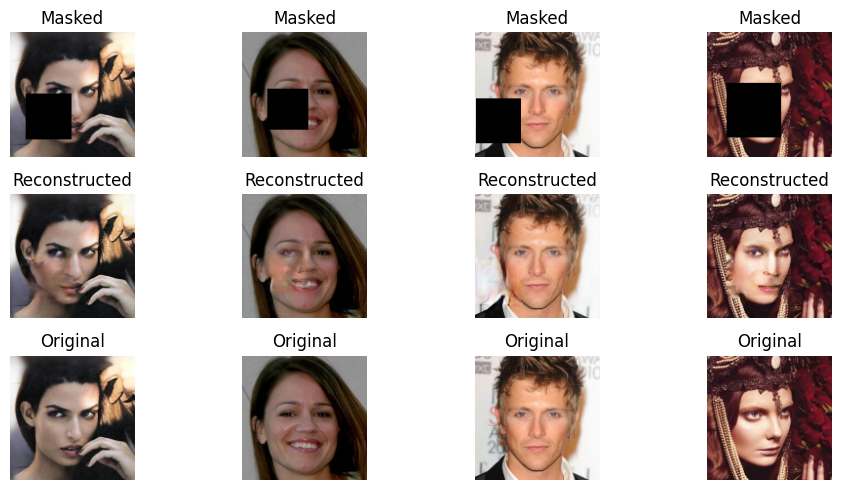

In [76]:

masked, original = next(iter(dataset))
pred = autoencoder.predict(masked)

plt.figure(figsize=(10,5))
for i in range(4):
    plt.subplot(3,4,i+1)
    plt.imshow(masked[i])
    plt.title("Masked")
    plt.axis('off')

    plt.subplot(3,4,i+5)
    plt.imshow(pred[i])
    plt.title("Reconstructed")
    plt.axis('off')

    plt.subplot(3,4,i+9)
    plt.imshow(original[i])
    plt.title("Original")
    plt.axis('off')

plt.tight_layout()
plt.show()


# **DCGAN Implementation**

Model Architecture (Encoder + Bottleneck + Decoder)

In [78]:
def build_autoencoder(img_size=128, latent_dim=256):
    inputs = layers.Input((img_size, img_size, 3))

    #  Encoder
    conv1 = layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    pool1 = layers.MaxPooling2D()(conv1)  # 64x64

    conv2 = layers.Conv2D(128, 3, padding='same', activation='relu')(pool1)
    pool2 = layers.MaxPooling2D()(conv2)  # 32x32

    conv3 = layers.Conv2D(256, 3, padding='same', activation='relu')(pool2)
    pool3 = layers.MaxPooling2D()(conv3)  # 16x16

    conv4 = layers.Conv2D(512, 3, padding='same', activation='relu')(pool3)
    pool4 = layers.MaxPooling2D()(conv4)  # 8x8

    # Bottleneck (Latent space)
    x = layers.Flatten()(pool4)
    latent = layers.Dense(latent_dim, activation='relu', name="latent_vector")(x)

    x = layers.Dense(8*8*512, activation='relu')(latent)
    x = layers.Reshape((8,8,512))(x)

    #  Decoder (U-Net Skip Style)
    x = layers.UpSampling2D()(x) # 16x16
    x = layers.Concatenate()([x, conv4]) # concatenate with conv4 (16x16)
    x = layers.Conv2D(512, 3, padding='same', activation='relu')(x)

    x = layers.UpSampling2D()(x) # 32x32
    x = layers.Concatenate()([x, conv3]) # concatenate with conv3 (32x32)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)

    x = layers.UpSampling2D()(x) # 64x64
    x = layers.Concatenate()([x, conv2]) # concatenate with conv2 (64x64)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)

    x = layers.UpSampling2D()(x) # 128x128
    x = layers.Concatenate()([x, conv1]) # concatenate with conv1 (128x128)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)

    outputs = layers.Conv2D(3, 3, activation='sigmoid', padding='same')(x)

    model = Model(inputs, outputs)
    return model

dcgan_autoencoder = build_autoencoder()
dcgan_autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_102 (Conv2D) │ (None, 128, 128,  │      1,792 │ input_layer_10[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 64, 64,    │          0 │ conv2d_102[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_103 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_28… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_29    │ (None, 32, 32,    │          0 │ conv2d_103[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_104 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_29… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 16, 16,    │          0 │ conv2d_104[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_105 (Conv2D) │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_30… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_31    │ (None, 8, 8, 512) │          0 │ conv2d_105[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 32768)     │          0 │ max_pooling2d_31… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent_vector       │ (None, 256)       │  8,388,864 │ flatten_7[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 32768)     │  8,421,376 │ latent_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, 8, 8, 512) │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_12    │ (None, 16, 16,    │          0 │ reshape_7[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_48      │ (None, 16, 16,    │          0 │ up_sampling2d_12… │
│ (Concatenate)       │ 1024)             │            │ conv2d_105[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_106 (Conv2D) │ (None, 16, 16,    │  4,719,104 │ concatenate_48[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_13    │ (None, 32, 32,    │          0 │ conv2d_106[0][0]  │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_49      │ (None, 32, 32,    │          0 │ up_sampling2d_13

 Total params: 25,404,931 (96.91 MB)

 Trainable params: 25,404,931 (96.91 MB)

 Non-trainable params: 0 (0.00 B)

Loss Function

In [79]:
# combine MAE + SSIM for sharper reconstructions

def loss_fn(y_true, y_pred):
    mae = tf.reduce_mean(tf.abs(y_true - y_pred))
    ssim = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return mae + 0.3 * ssim     # adjust 0.3 if nwwd moew sharper/softer


Compile & Train

In [80]:
dcgan_autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=loss_fn,
    metrics=["mae"]
)

history = dcgan_autoencoder.fit(
    dataset,
    epochs=5,
    batch_size=32,
    shuffle=True
)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 246s 126ms/step - loss: 0.1307 - mae: 0.0636
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 244s 127ms/step - loss: 0.0580 - mae: 0.0247
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 243s 127ms/step - loss: 0.0516 - mae: 0.0213
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 243s 127ms/step - loss: 0.0487 - mae: 0.0200
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 243s 127ms/step - loss: 0.0465 - mae: 0.0189


Reconstruct & Visualize Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


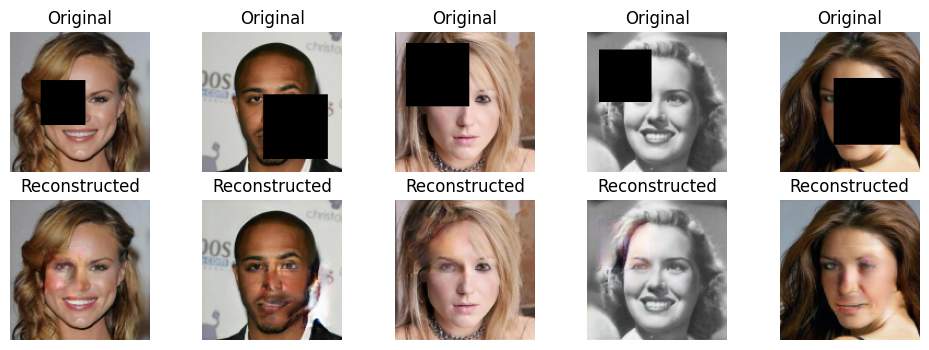

In [81]:

def show_compare(dataset, model, n=5):
    for imgs,_ in dataset.take(1):
        preds = model.predict(imgs[:n])

        plt.figure(figsize=(12,4))
        for i in range(n):
            # Original
            plt.subplot(2,n,i+1)
            plt.imshow(imgs[i])
            plt.title("Original")
            plt.axis('off')

            # Reconstructed
            plt.subplot(2,n,i+1+n)
            plt.imshow(preds[i])
            plt.title("Reconstructed")
            plt.axis('off')
        plt.show()

show_compare(dataset, autoencoder)


# **GAN Architecture for Restoration**

Generator (U-Net)

In [82]:
def build_generator(img_size=128):
    inputs = layers.Input(shape=(img_size, img_size, 3))

    # Encoder
    def down(x, f, bn=True):
        x = layers.Conv2D(f, 4, strides=2, padding='same')(x)
        if bn: x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(0.2)(x)
        return x

    d1 = down(inputs, 64, bn=False)
    d2 = down(d1, 128)
    d3 = down(d2, 256)
    d4 = down(d3, 512)
    d5 = down(d4, 512)
    d6 = down(d5, 512)

    # bottleneck
    b = layers.Conv2D(512, 4, strides=2, padding='same')(d6)
    b = layers.ReLU()(b)

    # Decoder
    def up(x, skip, f, dropout=False):
        x = layers.Conv2DTranspose(f, 4, strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        if dropout: x = layers.Dropout(0.5)(x)
        x = layers.Concatenate()([x, skip])
        x = layers.ReLU()(x)
        return x

    u1 = up(b, d6, 512, dropout=True)
    u2 = up(u1, d5, 512, dropout=True)
    u3 = up(u2, d4, 512)
    u4 = up(u3, d3, 256)
    u5 = up(u4, d2, 128)
    u6 = up(u5, d1, 64)

    outputs = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(u6)

    return Model(inputs, outputs, name="Generator")

generator = build_generator()
generator.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_111 (Conv2D) │ (None, 64, 64,    │      3,136 │ input_layer_11[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_26      │ (None, 64, 64,    │          0 │ conv2d_111[0][0]  │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_112 (Conv2D) │ (None, 32, 32,    │    131,200 │ leaky_re_lu_26[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_112[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_27      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_113 (Conv2D) │ (None, 16, 16,    │    524,544 │ leaky_re_lu_27[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_113[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_28      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_114 (Conv2D) │ (None, 8, 8, 512) │  2,097,664 │ leaky_re_lu_28[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_114[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_29      │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_115 (Conv2D) │ (None, 4, 4, 512) │  4,194,816 │ leaky_re_lu_29[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 512) │      2,048 │ conv2d_115[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_30      │ (None, 4, 4, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_116 (Conv2D) │ (None, 2, 2, 512) │  4,194,816 │ leaky_re_lu_30[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 512) │      2,048 │ conv2d_116[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_31      │ (None, 2, 2, 512) │          0 │ batch_normalizat

 Total params: 41,841,283 (159.61 MB)

 Trainable params: 41,833,475 (159.58 MB)

 Non-trainable params: 7,808 (30.50 KB)

Discriminator (PatchGAN — detects realism in patches)

In [83]:
def build_discriminator(img_size=128):
    inp = layers.Input(shape=(img_size, img_size, 3), name="input_image")   # masked
    target = layers.Input(shape=(img_size, img_size, 3), name="target_image") # real

    x = layers.Concatenate()([inp, target])

    def block(x, f, bn=True):
        x = layers.Conv2D(f, 4, strides=2, padding='same')(x)
        if bn: x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(0.2)(x)
        return x

    x = block(x, 64, bn=False)
    x = block(x, 128)
    x = block(x, 256)
    x = block(x, 512)

    out = layers.Conv2D(1, 4, padding='same')(x)

    return Model([inp, target], out, name="Discriminator")

discriminator = build_discriminator()
discriminator.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_58      │ (None, 128, 128,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 6)                │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_118 (Conv2D) │ (None, 64, 64,    │      6,208 │ concatenate_58[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_32      │ (None, 64, 64,    │          0 │ conv2d_118[0][0]  │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_119 (Conv2D) │ (None, 32, 32,    │    131,200 │ leaky_re_lu_32[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_119[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_33      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_120 (Conv2D) │ (None, 16, 16,    │    524,544 │ leaky_re_lu_33[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_120[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_34      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_121 (Conv2D) │ (None, 8, 8, 512) │  2,097,664 │ leaky_re_lu_34[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_121[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_35      │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_122 (Conv2D) │ (None, 8, 8, 1)   │      8,193 │ leaky_re_lu_35[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,771,393 (10.57 MB)

 Trainable params: 2,769,601 (10.57 MB)

 Non-trainable params: 1,792 (7.00 KB)

GAN Training Step (Adversarial + L1 Loss)

In [84]:

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output, real, fake, LAMBDA=100):
    gan_loss = loss_obj(tf.ones_like(fake_output), fake_output)
    l1_loss = tf.reduce_mean(tf.abs(real - fake))
    return gan_loss + LAMBDA * l1_loss

def discriminator_loss(real_output, fake_output):
    real_loss = loss_obj(tf.ones_like(real_output), real_output)
    fake_loss = loss_obj(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


Training Loop

In [85]:
@tf.function
def train_step(input_img, target_img):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_img = generator(input_img, training=True)

        real_out = discriminator([input_img, target_img], training=True)
        fake_out = discriminator([input_img, fake_img], training=True)

        gen_loss = generator_loss(fake_out, target_img, fake_img)
        disc_loss = discriminator_loss(real_out, fake_out)

    generator_optimizer.apply_gradients(zip(gen_tape.gradient(gen_loss, generator.trainable_variables),
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_tape.gradient(disc_loss, discriminator.trainable_variables),
                                                discriminator.trainable_variables))
    return gen_loss, disc_loss


def train_gan(dataset, epochs=5):
    for epoch in range(epochs):
        for masked, real in dataset:
            g, d = train_step(masked, real)
        print(f"Epoch[{epoch+1}] Gen:{g.numpy():.4f}, Disc:{d.numpy():.4f}")


Generate & Visualize Output

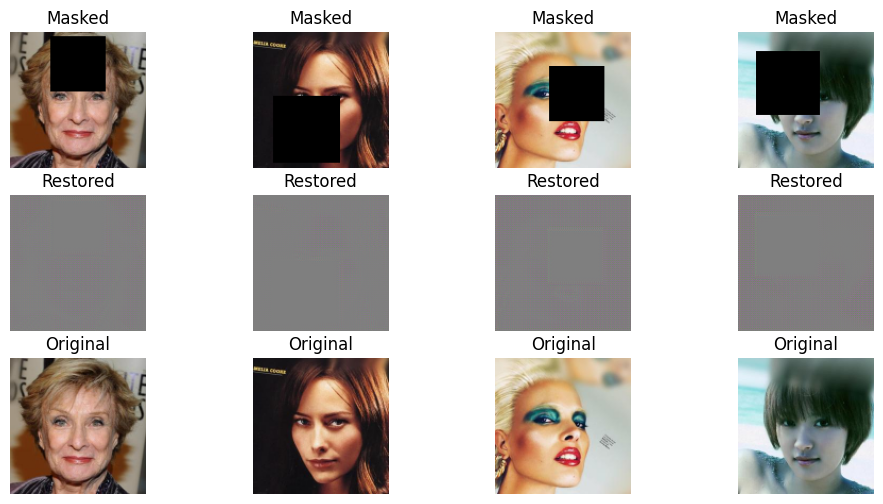

In [86]:
def test_gan(dataset, n=4):
    for masked, real in dataset.take(1):
        pred = generator(masked[:n], training=False)

        plt.figure(figsize=(12,6))
        for i in range(n):
            plt.subplot(3,n,i+1)
            plt.imshow(masked[i])
            plt.title("Masked")
            plt.axis('off')

            plt.subplot(3,n,i+1+n)
            plt.imshow(pred[i]*0.5+0.5)   # convert from tanh to [0,1]
            plt.title("Restored")
            plt.axis('off')

            plt.subplot(3,n,i+1+2*n)
            plt.imshow(real[i])
            plt.title("Original")
            plt.axis('off')

        plt.show()

test_gan(dataset)


# **Hybrid Context Encoder (Autoencoder + Adversarial Loss)**

Hybrid Training Class (custom training loop)

In [87]:

lambda_recon = 0.99
lambda_adv   = 0.01

class ContextEncoder(tf.keras.Model):
    def __init__(self, generator, discriminator):
        super().__init__()
        self.gen = generator
        self.disc = discriminator

        self.gen_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        self.disc_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

        self.bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    def recon_loss(self, real, fake):
        return tf.reduce_mean(tf.square(real - fake))   # L2 loss

    def adv_loss(self, fake_pred):
        return self.bce(tf.ones_like(fake_pred), fake_pred)

    @tf.function
    def train_step(self, batch):
        masked, real = batch

        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            fake = self.gen(masked, training=True)

            real_pred = self.disc([masked, real], training=True)
            fake_pred = self.disc([masked, fake], training=True)

            # Hybrid Loss
            L_rec = self.recon_loss(real, fake)
            L_adv = self.adv_loss(fake_pred)
            gen_loss = lambda_recon * L_rec + lambda_adv * L_adv

            disc_loss = (self.bce(tf.ones_like(real_pred), real_pred) +
                         self.bce(tf.zeros_like(fake_pred), fake_pred))

        grads_g = g_tape.gradient(gen_loss, self.gen.trainable_variables)
        grads_d = d_tape.gradient(disc_loss, self.disc.trainable_variables)

        self.gen_opt.apply_gradients(zip(grads_g, self.gen.trainable_variables))
        self.disc_opt.apply_gradients(zip(grads_d, self.disc.trainable_variables))

        return {"gen_loss": gen_loss, "disc_loss": disc_loss,
                "recon_loss": L_rec, "adv_loss": L_adv}


context_model = ContextEncoder(dcgan_autoencoder, discriminator)

Train Hybrid Model

In [88]:
def train_context_encoder(model, dataset, epochs=5):
    log = {"gen":[], "disc":[], "rec":[], "adv":[]}

    for e in range(epochs):
        for batch in dataset:
            out = model.train_step(batch)

        log["gen"].append(float(out["gen_loss"]))
        log["disc"].append(float(out["disc_loss"]))
        log["rec"].append(float(out["recon_loss"]))
        log["adv"].append(float(out["adv_loss"]))

        print(f"Epoch {e+1}/{epochs} | "
              f"GEN:{out['gen_loss']:.4f}  DISC:{out['disc_loss']:.4f} "
              f"REC:{out['recon_loss']:.4f} ADV:{out['adv_loss']:.4f}")

    return log

logs = train_context_encoder(context_model, dataset, epochs=5)


Epoch 1/5 | GEN:0.0108  DISC:1.3155 REC:0.0038 ADV:0.7075
Epoch 2/5 | GEN:0.0133  DISC:1.3753 REC:0.0044 ADV:0.8969
Epoch 3/5 | GEN:0.0115  DISC:1.3871 REC:0.0031 ADV:0.8434
Epoch 4/5 | GEN:0.0098  DISC:1.3340 REC:0.0027 ADV:0.7146
Epoch 5/5 | GEN:0.0107  DISC:1.2566 REC:0.0029 ADV:0.7830


Loss Graphs for Report

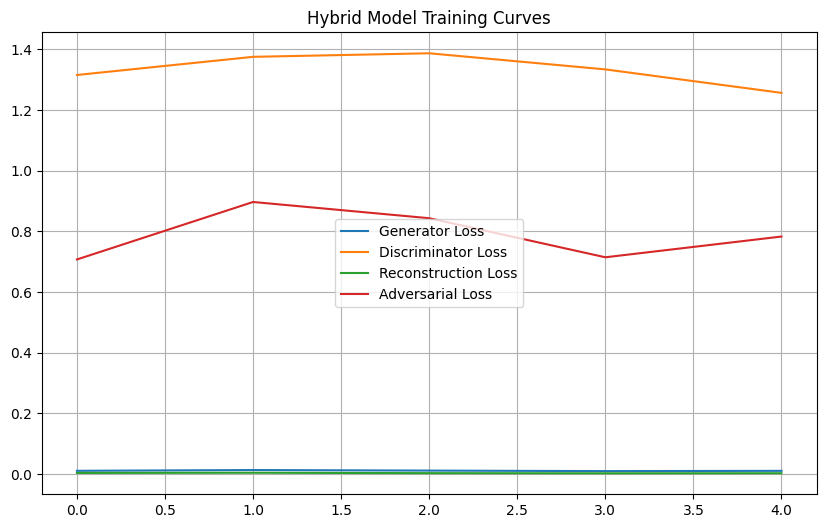

In [89]:

plt.figure(figsize=(10,6))
plt.plot(logs["gen"], label="Generator Loss")
plt.plot(logs["disc"], label="Discriminator Loss")
plt.plot(logs["rec"], label="Reconstruction Loss")
plt.plot(logs["adv"], label="Adversarial Loss")
plt.legend(); plt.grid(); plt.title("Hybrid Model Training Curves")
plt.show()


Compare Model Outputs

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


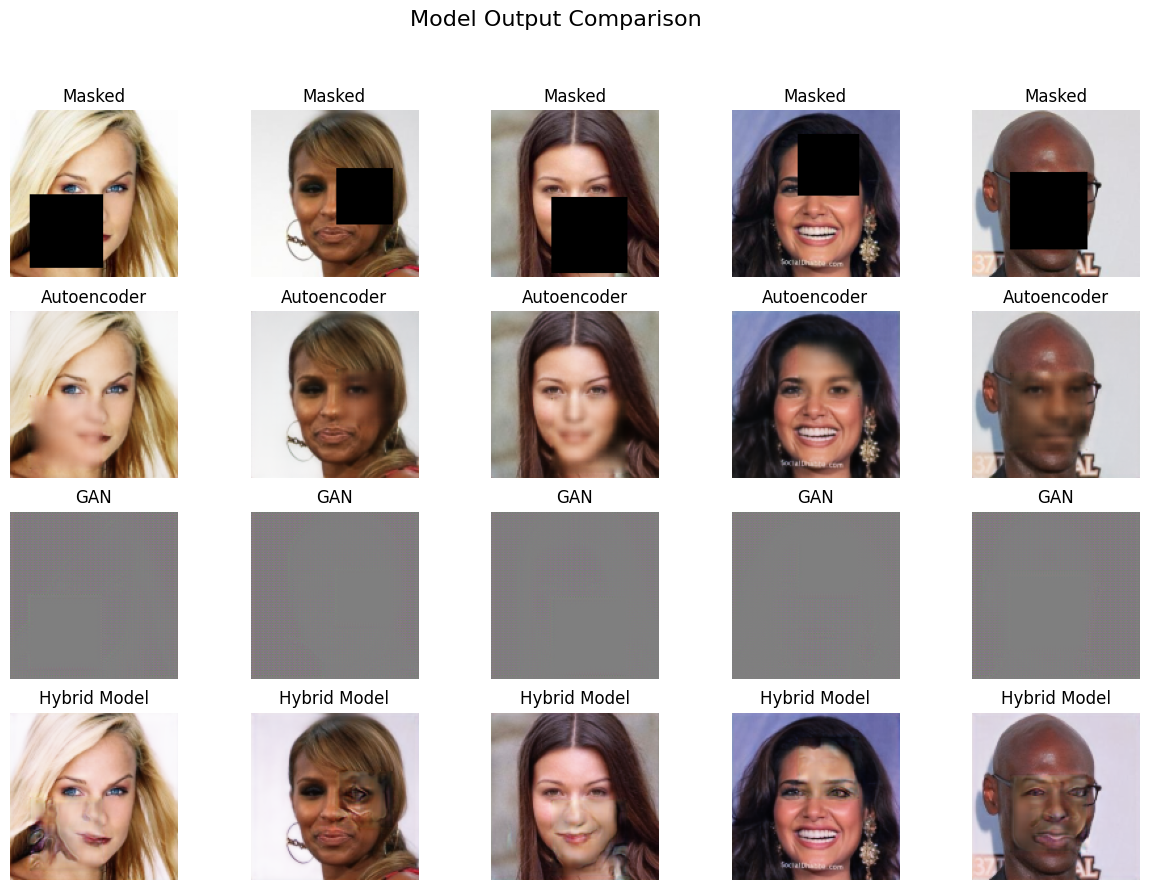

In [90]:
def compare_models(dataset, n=5):
    masked, real = next(iter(dataset))
    # Assuming 'unet_autoencoder' holds the first autoencoder model (from VKD6ACJ-1LXm)
    # You need to ensure cell VKD6ACJ-1LXm defines 'unet_autoencoder = build_autoencoder()'
    pred_ae  = unet_autoencoder.predict(masked[:n])
    pred_gan = generator.predict(masked[:n])
    pred_hyb = context_model.gen.predict(masked[:n])

    plt.figure(figsize=(15,10))
    for i in range(n):
        # masked
        plt.subplot(4,n,i+1)
        plt.imshow(masked[i]); plt.title("Masked"); plt.axis('off')
        # AE
        plt.subplot(4,n,i+1+n)
        plt.imshow(pred_ae[i]); plt.title("Autoencoder"); plt.axis('off')
        # GAN
        plt.subplot(4,n,i+1+2*n)
        plt.imshow((pred_gan[i]*0.5+0.5)); plt.title("GAN"); plt.axis('off')
        # Hybrid
        plt.subplot(4,n,i+1+3*n)
        plt.imshow(pred_hyb[i]); plt.title("Hybrid Model"); plt.axis('off')

    plt.suptitle("Model Output Comparison", fontsize=16)
    plt.show()

compare_models(dataset)

Evaluation Metrics (SSIM & PSNR)

In [91]:
import tensorflow.image as tfi

def evaluate(dataset, model, name):
    ssim_scores, psnr_scores = [], []
    for masked, real in dataset.take(50):  # sample evaluation
        pred = model.predict(masked)
        for i in range(len(real)):
            ssim_scores.append(tf.reduce_mean(tfi.ssim(real[i], pred[i], max_val=1.0)))
            psnr_scores.append(tfi.psnr(real[i], pred[i], max_val=1.0))
    print(f"\n{name} Results:")
    print(f"SSIM: {np.mean(ssim_scores):.4f}")
    print(f"PSNR: {np.mean(psnr_scores):.4f}")

evaluate(dataset, unet_autoencoder, "U-Net Autoencoder")
evaluate(dataset, generator, "GAN")
evaluate(dataset, context_model.gen, "Hybrid")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━